In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# GradientBoosting

Dieses Notizbuch umfasst einen fein abgestimmten XGBoost, Random Forest und einen Ensemble-Stacking-Ansatz. Die Einbeziehung von detailliertem Hyperparameter-Tuning und der Visualisierung von Ergebnissen deutet auf einen robusten Ansatz zur Modellentwicklung und -bewertung hin. Die Modelle werden aus der Perspektive von RMSE, MAPE, MAE, R² und Rechenkomplexität bewertet. Dieses Notizbuch legt nahe, dass RMSE das meiste Gewicht bei der Bewertung der Vorhersage eines Modells hat. Im Allgemeinen ist das bestperformende Modell der XGBoost in Bezug auf RMSE und Rechenleistung.

## Hyperparamter Tuning

In [ ]:
pd.set_option('display.max_columns', None)

# Read in the data
cars = pd.read_csv("Cars_Data_Model.csv", sep=";", index_col=0)
cars = cars.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Behalte nur Samples mit einem Preis kleiner als 300,000 --> Ausreisser entfernen
cars = cars[cars["Preis"] < 300000]

In [ ]:
# Define X and y and drop features
X = cars.drop("Preis", axis=1)
y = cars.loc[:,"Preis"]


# Define Train Test Eval
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)
y_val = np.log(y_val)

# Data Scaling
scaler = RobustScaler()
scaler.fit(X_train)

# Scale the three datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [ ]:
n_estimators = [100, 200, 300]
max_depths = [3, 4, 5]
learning_rates = [0.2, 0.3, 0.5]

In [ ]:
rmse_train_list = []
rmse_val_list = []
parameters_list = []


# Manual GridSearch
for estimator in n_estimators:
    for max_depth in max_depths:
        for rate in learning_rates:

            # Instantiate Model
            gradient_boosting = GradientBoostingRegressor(n_estimators = estimator, max_depth = max_depth, learning_rate = rate, random_state=42)

            # Fit the Model
            gradient_boosting.fit(X_train_scaled, y_train)

            # Predict
            y_train_pred_gb = gradient_boosting.predict(X_train_scaled)
            y_val_pred_gb = gradient_boosting.predict(X_val_scaled)


            # Evaluate RMSE
            rmse_train_gb = mean_squared_error(np.exp(y_train), np.exp(y_train_pred_gb), squared=False)
            rmse_val_gb = mean_squared_error(np.exp(y_val), np.exp(y_val_pred_gb), squared=False)

            # Append
            rmse_train_list.append(rmse_train_gb)
            rmse_val_list.append(rmse_val_gb)
            parameters_list.append([estimator, max_depth, rate])

            print(f"RMSE Train: {rmse_train_gb}\nRMSE Val: {rmse_val_gb}")


# Arrays convert to DF
results_df = pd.DataFrame({
    'rmse_train': rmse_train_list,
    'rmse_val': rmse_val_list,
    'parameters': parameters_list}).sort_values(by='rmse_val')

RMSE Train: 10698.759020317142
RMSE Val: 10729.308822668852
RMSE Train: 9978.713374004983
RMSE Val: 10245.632395881128
RMSE Train: 9210.963531400117
RMSE Val: 9644.495420590401
RMSE Train: 9647.223662379105
RMSE Val: 10056.184833489257
RMSE Train: 9016.529339286137
RMSE Val: 9407.690749604979
RMSE Train: 8251.261846980024
RMSE Val: 9233.626373207266
RMSE Train: 8598.913591166769
RMSE Val: 9074.11306913583
RMSE Train: 8255.754628319602
RMSE Val: 8920.6325556597
RMSE Train: 7429.162584310596
RMSE Val: 8570.161392447964
RMSE Train: 9428.299104128011
RMSE Val: 9546.11437152774
RMSE Train: 8841.42600759516
RMSE Val: 9219.224648559539
RMSE Train: 8063.812115037979
RMSE Val: 8832.796678531775
RMSE Train: 8576.452408421843
RMSE Val: 9083.415892742129
RMSE Train: 7860.506434670508
RMSE Val: 8437.758483593687
RMSE Train: 6986.606293552373
RMSE Val: 8545.571945058313
RMSE Train: 7594.125843893016
RMSE Val: 8367.294083398509
RMSE Train: 6915.871537767831
RMSE Val: 8207.87092561377
RMSE Train: 6222

In [ ]:
results_df["delta"] = results_df["rmse_val"] - results_df["rmse_train"]
results_df

,rmse_train,rmse_val,parameters,delta
25,6103.529741,7798.456280,"[300, 5, 0.3]",1694.926539
22,7072.612475,7910.366434,"[300, 4, 0.3]",837.753958
24,6876.515621,7936.287803,"[300, 5, 0.2]",1059.772182
26,5375.182387,7969.220303,"[300, 5, 0.5]",2594.037916
17,6222.869061,8046.156950,"[200, 5, 0.5]",1823.287889
20,7307.948985,8185.675588,"[300, 3, 0.5]",877.726603
16,6915.871538,8207.870926,"[200, 5, 0.3]",1291.999388
23,6105.415517,8258.217426,"[300, 4, 0.5]",2152.801909
15,7594.125844,8367.294083,"[200, 5, 0.2]",773.168240
13,7860.506435,8437.758484,"[200, 4, 0.3]",577.252049


Optimale Kombination: [300, 4, 0.3]



Als Veranschaulichung; wie durch die Log-Transformation der Zielvariable/Target sich die Verteilung einer Nonrmalverteilung annähert:

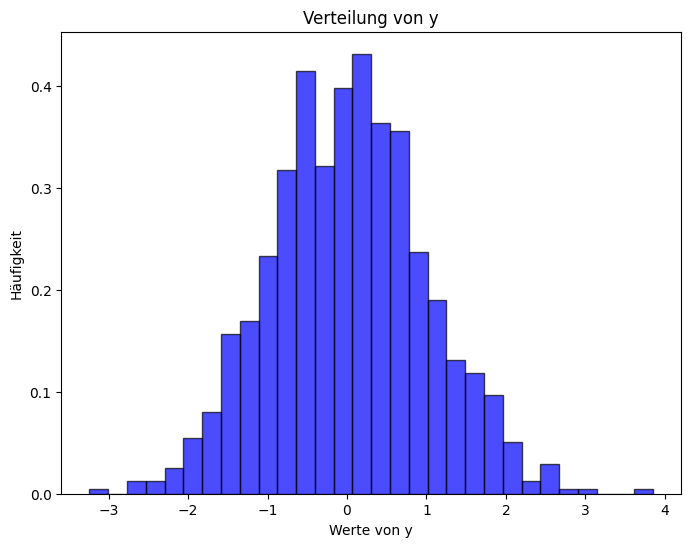

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Annahme: y ist eine Pandas Series
# Hier ein Beispiel mit zufälligen Daten:
np.random.seed(42)
y = np.random.normal(loc=0, scale=1, size=1000)

# Erstelle eine Pandas Series
y_series = pd.Series(y)

# Plot mit Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(y_series, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Verteilung von y')
plt.xlabel('Werte von y')
plt.ylabel('Häufigkeit')
plt.show()




## Model Training and Evaluation

In [ ]:
# Instantiate Model
gradient_boosting = GradientBoostingRegressor(n_estimators = 300, max_depth = 5, learning_rate = 0.3, random_state=42)

# Fit the Model
gradient_boosting.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.3, max_depth=4, n_estimators=300,
                          random_state=42)

In [ ]:
# Predict/Vorhersagen
y_train_pred_gb = gradient_boosting.predict(X_train_scaled)
y_val_pred_gb = gradient_boosting.predict(X_val_scaled)
y_test_pred_gb = gradient_boosting.predict(X_test_scaled)


# Berechnen von RMSE
rmse_train_gb = mean_squared_error(np.exp(y_train), np.exp(y_train_pred_gb), squared=False)
rmse_test_gb = mean_squared_error(np.exp(y_test), np.exp(y_test_pred_gb), squared=False)
rmse_val_gb = mean_squared_error(np.exp(y_val), np.exp(y_val_pred_gb), squared=False)
print(f"RMSE Train: {rmse_train_gb}\nRMSE Val: {rmse_val_gb}\nRMSE Test: {rmse_test_gb}")

print()

# Berechnen von MAPE
mape_train_gb = mean_absolute_percentage_error(np.exp(y_train), np.exp(y_train_pred_gb))
mape_val_gb = mean_absolute_percentage_error(np.exp(y_val), np.exp(y_val_pred_gb))
mape_test_gb = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_test_pred_gb))
print(f"MAPE Train: {mape_train_gb}\nMAPE Val: {mape_val_gb}\nMAPE Test: {mape_test_gb}")

print()

# Berechnen von MAE
mae_train_gb = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred_gb))
mae_val_gb = mean_absolute_error(np.exp(y_val), np.exp(y_val_pred_gb))
mae_test_gb = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred_gb))
print(f"MAE Train: {mae_train_gb}\nMAE Val: {mae_val_gb}\nMAE Test: {mae_test_gb}")



print()

# Berechnen von R^2
r2_train_gb = r2_score(np.exp(y_train), np.exp(y_train_pred_gb))
r2_val_gb = r2_score(np.exp(y_val), np.exp(y_val_pred_gb))
r2_test_gb = r2_score(np.exp(y_test), np.exp(y_test_pred_gb))

print(f"R^2 Train: {r2_train_gb}\nR^2 Val: {r2_val_gb}\nR^2 Test: {r2_test_gb}")


RMSE Train: 7072.612475448848
RMSE Val: 7910.366433809568
RMSE Test: 9676.748496591717

MAPE Train: 0.13041363191576902
MAPE Val: 0.1476504185352258
MAPE Test: 0.1474435611081108

MAE Train: 3849.202877383302
MAE Val: 4130.44917013345
MAE Test: 4471.623655756112

R^2 Train: 0.9372401691701623
R^2 Val: 0.9195139999078847
R^2 Test: 0.8865245701980526


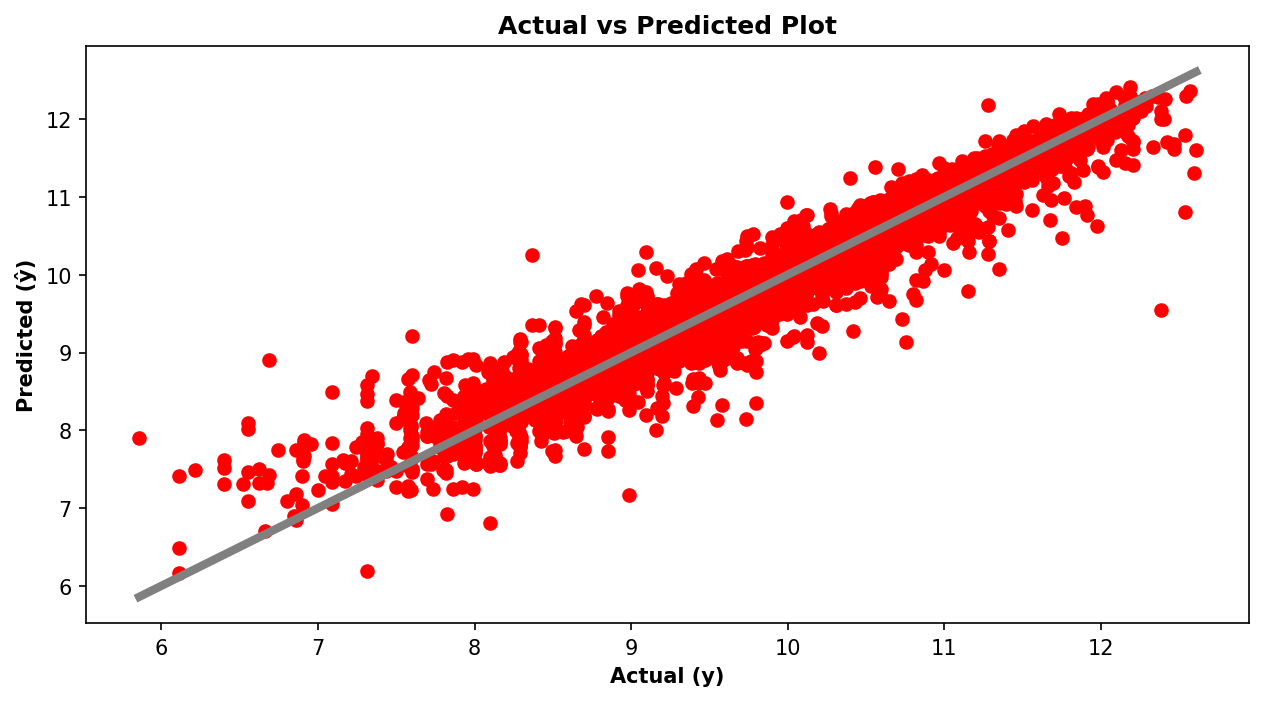

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Umkehrung der Logarithmustransformation
y_test_original = np.exp(y_test)
y_test_pred_original = np.exp(y_test_pred_gb)

# Bestimmung der minimalen und maximalen Werte
min_value = np.array([y_test_original.min(), y_test_pred_original.min()]).min()
max_value = np.array([y_test_original.max(), y_test_pred_original.max()]).max()

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.scatter(y_test_original, y_test_pred_original, color="blue")
ax.plot([min_value, max_value], [min_value, max_value], lw=4, color="grey")

ax.set_title("Actual vs Predicted Plot", fontweight="bold")
ax.set_xlabel('Actual (y)', fontweight="bold")
ax.set_ylabel('Predicted (ŷ)', fontweight="bold")

plt.show()


# Random Forest

## Hyperparameter Tuning, Model Training und Evaluation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

# Read in the data
cars = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Cars_Data_Model.csv", sep=";", index_col=0)
cars = cars.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Behalte nur Samples mit einem Preis kleiner als 300,000 --> Ausreisser entfernen
cars = cars[cars["Preis"] < 300000]

In [ ]:
# Define X and y and drop features
X = cars.drop("Preis", axis=1)
y = cars.loc[:,"Preis"]


# Define Train Test Eval
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)
y_val = np.log(y_val)

# Data Scaling
scaler = RobustScaler()
scaler.fit(X_train)

# Scale the three datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [ ]:
n_estimator=[1000, 500]
max_depths = [10, 20]
min_samples_split = [4, 7]

In [ ]:
rmse_train_list = []
rmse_val_list = []
parameters_list = []


# Manual GridSearch
for estimator in n_estimator:
    for max_depth in max_depths:
        for min_samples in min_samples_split:

            # Instantiate Model
            random_forest = RandomForestRegressor(criterion = "squared_error", n_estimators = estimator, max_depth = max_depth, min_samples_split = min_samples, random_state = 42)

            # Fit the Model
            random_forest.fit(X_train_scaled, y_train)

            # Predict
            y_train_pred_r = random_forest.predict(X_train_scaled)
            y_val_pred_r = random_forest.predict(X_val_scaled)


            # Evaluate RMSE
            rmse_train_r = mean_squared_error(np.exp(y_train), np.exp(y_train_pred_r), squared=False)
            rmse_val_r = mean_squared_error(np.exp(y_val), np.exp(y_val_pred_r), squared=False)

            # Append
            rmse_train_list.append(rmse_train_r)
            rmse_val_list.append(rmse_val_r)
            parameters_list.append([estimator, max_depth, min_samples])

            print(f"RMSE Train: {rmse_train_r}\nRMSE Val: {rmse_val_r}")


# Arrays convert to DF
results_df = pd.DataFrame({
    'rmse_train': rmse_train_list,
    'rmse_val': rmse_val_list,
    'parameters': parameters_list}).sort_values(by='rmse_val')

RMSE Train: 8186.201364555681
RMSE Val: 9723.259209886148
RMSE Train: 8287.21505772604
RMSE Val: 9750.013042320064
RMSE Train: 4151.523372366886
RMSE Val: 7992.191172783156
RMSE Train: 4707.267374396596
RMSE Val: 8061.402821667494
RMSE Train: 8173.890713404659
RMSE Val: 9720.303918305519
RMSE Train: 8275.630548713572
RMSE Val: 9744.467216332356
RMSE Train: 4144.789902251129
RMSE Val: 7991.151823331751
RMSE Train: 4702.080779597086
RMSE Val: 8064.269651974551


In [ ]:
results_df["delta"] = results_df["rmse_val"] - results_df["rmse_train"]
results_df

,rmse_train,rmse_val,parameters,delta
6,4144.789902,7991.151823,"[500, 20, 4]",3846.361921
2,4151.523372,7992.191173,"[1000, 20, 4]",3840.667800
3,4707.267374,8061.402822,"[1000, 20, 7]",3354.135447
7,4702.080780,8064.269652,"[500, 20, 7]",3362.188872
4,8173.890713,9720.303918,"[500, 10, 4]",1546.413205
0,8186.201365,9723.259210,"[1000, 10, 4]",1537.057845
5,8275.630549,9744.467216,"[500, 10, 7]",1468.836668
1,8287.215058,9750.013042,"[1000, 10, 7]",1462.797985


In [ ]:
# Instantiate Model
random_forest = RandomForestRegressor(criterion = "squared_error", n_estimators = 500, max_depth = 20, min_samples_split = 4, random_state = 42)

# Fit the Model
random_forest.fit(X_train_scaled, y_train)

# Predict
y_train_pred_rf = random_forest.predict(X_train_scaled)
y_val_pred_rf = random_forest.predict(X_val_scaled)
y_test_pred_rf = random_forest.predict(X_test_scaled)

RMSE Train: 4144.789902251129
RMSE Val: 7991.151823331751
RMSE Test: 9215.405213666043


In [ ]:
# Berechnen von RMSE
rmse_train_rf = mean_squared_error(np.exp(y_train), np.exp(y_train_pred_rf), squared=False)
rmse_test_rf = mean_squared_error(np.exp(y_test), np.exp(y_test_pred_rf), squared=False)
rmse_val_rf = mean_squared_error(np.exp(y_val), np.exp(y_val_pred_rf), squared=False)
print(f"RMSE Train: {rmse_train_rf}\nRMSE Val: {rmse_val_rf}\nRMSE Test: {rmse_test_rf}")

print()

# Berechnen von MAPE
mape_train_rf = mean_absolute_percentage_error(np.exp(y_train), np.exp(y_train_pred_rf))
mape_val_rf = mean_absolute_percentage_error(np.exp(y_val), np.exp(y_val_pred_rf))
mape_test_rf = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_test_pred_rf))
print(f"MAPE Train: {mape_train_rf}\nMAPE Val: {mape_val_rf}\nMAPE Test: {mape_test_rf}")

print()

# Berechnen von MAE
mae_train_rf = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred_rf))
mae_val_rf = mean_absolute_error(np.exp(y_val), np.exp(y_val_pred_rf))
mae_test_rf = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred_rf))
print(f"MAE Train: {mae_train_rf}\nMAE Val: {mae_val_rf}\nMAE Test: {mae_test_rf}")

print()

# Berechnen von R^2
r2_train_rf = r2_score(np.exp(y_train), np.exp(y_train_pred_rf))
r2_val_rf = r2_score(np.exp(y_val), np.exp(y_val_pred_rf))
r2_test_rf = r2_score(np.exp(y_test), np.exp(y_test_pred_rf))
print(f"R^2 Train: {r2_train_rf}\nR^2 Val: {r2_val_rf}\nR^2 Test: {r2_test_rf}")


RMSE Train: 4144.789902251129
RMSE Val: 7991.151823331751
RMSE Test: 9215.405213666043

MAPE Train: 0.06798513622263228
MAPE Val: 0.13793925127669335
MAPE Test: 0.13650711378677088

MAE Train: 2008.0703188518858
MAE Val: 3689.6894367798045
MAE Test: 3904.921560819623

R^2 Train: 0.9784460395695561
R^2 Val: 0.917861663179282
R^2 Test: 0.8970866294909672


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

min_value = np.array([y_test.min(), y_test_pred_rf.min()]).min()
max_value = np.array([y_test.max(), y_test_pred_rf.max()]).max()

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.scatter(y_test, y_test_pred_rf, color="green")
ax.plot([min_value, max_value], [min_value, max_value], lw=4, color="grey")




ax.set_title("Actual vs Predicted Plot", fontweight="bold")
ax.set_xlabel('Actual (y)', fontweight="bold")
ax.set_ylabel('Predicted (ŷ)', fontweight="bold")

plt.show()

# Stacking

## Model Training mit gefundenen Hyperparametern und Evaluation

Die beiden optimalen Modelle von oben stacken:

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [21]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

# Read in the data
cars = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/Project/data/final/Cars_Data_Model.csv", sep=";", index_col=0)
cars = cars.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Behalte nur Samples mit einem Preis kleiner als 300,000 --> Ausreisser entfernen
cars = cars[cars["Preis"] < 300000]

In [23]:
# Define X and y and drop features
X = cars.drop("Preis", axis=1)
y = cars.loc[:,"Preis"]


# Define Train Test Eval
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

y_train = np.log(y_train)
y_test = np.log(y_test)
y_val = np.log(y_val)

# Data Scaling
scaler = RobustScaler()
scaler.fit(X_train)

# Scale the three datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import numpy as np

# Basis-Modelle
estimators = [('random_forest', RandomForestRegressor(criterion = "squared_error", n_estimators = 500, max_depth = 20, min_samples_split = 4, random_state = 42)), ('gradient_boosting', GradientBoostingRegressor(n_estimators = 300, max_depth = 5, learning_rate = 0.3, random_state=42))]

# Stacking Regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42))

# Training des Stacking-Modells
stacking_regressor.fit(X_train_scaled, y_train)

# Vorhersagen treffen
y_train_pred = stacking_regressor.predict(X_train_scaled)
y_test_pred = stacking_regressor.predict(X_test_scaled)
y_val_pred = stacking_regressor.predict(X_val_scaled)

In [25]:
# Evaluation
rmse_train = mean_squared_error(np.exp(y_train), np.exp(y_train_pred), squared=False)
rmse_test = mean_squared_error(np.exp(y_test), np.exp(y_test_pred), squared=False)
rmse_val = mean_squared_error(np.exp(y_val), np.exp(y_val_pred), squared=False)

mape_train = mean_absolute_percentage_error(np.exp(y_train), np.exp(y_train_pred))
mape_val = mean_absolute_percentage_error(np.exp(y_val), np.exp(y_val_pred))
mape_test = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_test_pred))

mae_train = mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))
mae_val = mean_absolute_error(np.exp(y_val), np.exp(y_val_pred))
mae_test = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))

r2_train = r2_score(np.exp(y_train), np.exp(y_train_pred))
r2_val = r2_score(np.exp(y_val), np.exp(y_val_pred))
r2_test = r2_score(np.exp(y_test), np.exp(y_test_pred))

# Ergebnisse ausgeben
print(f"RMSE Train: {rmse_train}\nRMSE Val: {rmse_val}\nRMSE Test: {rmse_test}\n")
print(f"MAPE Train: {mape_train}\nMAPE Val: {mape_val}\nMAPE Test: {mape_test}\n")
print(f"MAE Train: {mae_train}\nMAE Val: {mae_val}\nMAE Test: {mae_test}\n")
print(f"R^2 Train: {r2_train}\nR^2 Val: {r2_val}\nR^2 Test: {r2_test}")

RMSE Train: 5164.273297079453
RMSE Val: 8065.554480840216
RMSE Test: 9042.298401369137

MAPE Train: 0.10096915848265414
MAPE Val: 0.14635686086623034
MAPE Test: 0.14297181259868308

MAE Train: 2855.8314345583744
MAE Val: 3961.3128693967087
MAE Test: 4126.184642078729

R^2 Train: 0.9665388799928557
R^2 Val: 0.916325023467257
R^2 Test: 0.9009166688836803


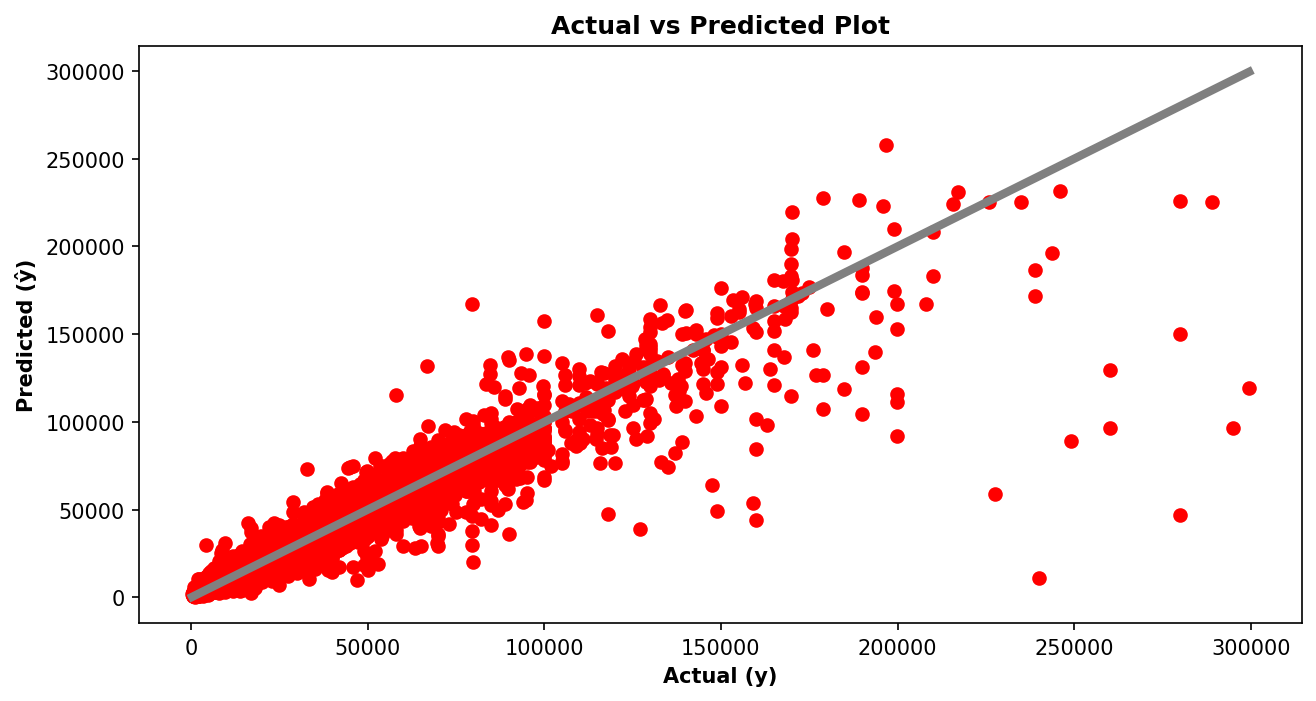

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Umkehrung der Logarithmustransformation
y_test_original = np.exp(y_test)
y_test_pred_original = np.exp(y_test_pred)

# Bestimmung der minimalen und maximalen Werte
min_value = np.array([y_test_original.min(), y_test_pred_original.min()]).min()
max_value = np.array([y_test_original.max(), y_test_pred_original.max()]).max()

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.scatter(y_test_original, y_test_pred_original, color="red")
ax.plot([min_value, max_value], [min_value, max_value], lw=4, color="grey")

ax.set_title("Actual vs Predicted Plot", fontweight="bold")
ax.set_xlabel('Actual (y)', fontweight="bold")
ax.set_ylabel('Predicted (ŷ)', fontweight="bold")

plt.show()
